<i>## Comments will be provided using this format. Key takeaway: groups are encouraged to change the formatting, but not the structure. Groups are also allowed to create additional notebooks - for instance, create one notebook for data exploration, and one notebook for each preprocessing-modelling-evaluation pipeline -, but must strive to keep an unified style across notebooks.</i>

#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Notebook Title`

#### Group:
- `Group member #1`
- `(...)`
- `Group member #5`

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Data Understanding](#P1)
- [2. General Data Preparation](#P2) 
- [3. Multilabel Classification (Information Requirement 3311)](#P3)
    - [3.1 Specific Data Preparation](#P31)
    - [3.2 Model Implementation](#P32)
    - [3.3 Model Evaluation](#P3n)
- [4. Sentiment Analysis (Information Requirement 3312)](#P4)
    - [4.1 Specific Data Preparation](#P41)
    - [4.2 Model Implementation](#P42)
    - [4.3 Model Evaluation](#P43)
- [...]
- [N. Additional Tasks (Information Requirements 332n)](#Pn)
    - [N.1 Specific Data Preparation](#Pn1)
    - [N.2 Model Implementation](#Pn2)
    - [N.3 Model Evaluation](#Pn3)

<i>## Note that the notebook structure differs from the report: instead of following the CRISP-DM phases and then specifying the different problems inside the phases, the notebook is structured by problem, with the CRISP-DM phases being defined for each specific problem.

In [2]:
## All imports must be concentrated on a cell that immediately follow the table of contents
import math
import time
import pandas as pd
import matplotlib.pyplot as plt

#without truncation
pd.set_option('display.max_colwidth', None)

<font color='#BFD72F' size=5>1. Data Understanding</font> <a class="anchor" id="P1"></a>
  
[Back to TOC](#toc)

<i>## Imports.</i>

In [48]:
reviews=pd.read_csv('data/reviews_initial_preproc.csv')
restaurants=pd.read_csv('data/restaurants_initial_preproc.csv') 
restaurants['Collections'].fillna('[]', inplace=True)
restaurants['Collections'] = restaurants['Collections'].apply(lambda x: eval(x))
restaurants['Cuisines'] = restaurants['Cuisines'].apply(lambda x: eval(x))

## Restaurant data exploration


In [49]:
restaurants.head()

,Name,Cost,Collections,Cuisines,N_collections,open time,closing time
0,Beyond Flavours,800,"[Food Hygiene Rated Restaurants in Hyderabad, Corporate Favorites, Great Buffets, Top-Rated, Gold Curated, Live Sports Screenings]","[Chinese, Continental, Kebab, European, South Indian, North Indian]",6,12,23
1,Paradise,800,[Hyderabad's Hottest],"[Biryani, North Indian, Chinese]",1,11,23
2,Flechazo,1300,"[Great Buffets, Hyderabad's Hottest]","[Asian, Mediterranean, North Indian, Desserts]",2,11,23
3,Shah Ghouse Hotel & Restaurant,800,[Late Night Restaurants],"[Biryani, North Indian, Chinese, Seafood, Beverages]",1,12,2
4,Over The Moon Brew Company,1200,"[Best Bars & Pubs, Food Hygiene Rated Restaurants in Hyderabad, Top-Rated, Gold Curated, Hyderabad's Hottest]","[Asian, Continental, North Indian, Chinese, Mediterranean]",5,12,24


In [50]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           105 non-null    object
 1   Cost           105 non-null    int64 
 2   Collections    105 non-null    object
 3   Cuisines       105 non-null    object
 4   N_collections  105 non-null    int64 
 5   open time      105 non-null    int64 
 6   closing time   105 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 5.9+ KB


In [51]:
restaurants.describe()

,Cost,N_collections,open time,closing time
count,105.000000,105.000000,105.000000,105.000000
mean,861.428571,1.009524,11.028571,18.971429
std,510.149730,1.451095,2.826581,8.471056
min,150.000000,0.000000,1.000000,1.000000
25%,500.000000,0.000000,11.000000,22.000000
50%,700.000000,0.000000,12.000000,23.000000
75%,1200.000000,1.000000,12.000000,23.000000
max,2800.000000,7.000000,24.000000,24.000000


In [52]:
#there is no restaunt duplicates
restaurants['Name'].nunique()

105

In [53]:
cuisines_exploded = restaurants['Cuisines'].explode().explode()
collections_exploded = restaurants['Collections'].explode().explode()

In [54]:
restaurant_agg = restaurants_exploded.groupby(['Cuisines', 'Collections']).agg(
    total_cost=('Cost', 'mean'), # Sum of 'Cost'
    count=('Cost', 'count')     # Count of restaurants
)

# Sort the result by 'total_cost' in descending order and get the top 10 rows
restaurant_agg.sort_values(by='total_cost', ascending=False).head(10)

,,total_cost,count
Cuisines,Collections,,
"['Continental', 'Italian', 'North Indian', 'Chinese', 'Asian']",['Sunday Brunches'],2800.0,1
"['Modern Indian', 'Asian', 'Continental', 'Italian']","['Sunday Brunches', 'Great Breakfasts', 'Function Venues', 'Ramzan Mubarak']",2500.0,1
"['North Indian', 'Chinese', 'Continental']",['Trending This Week'],1900.0,1
"['North Indian', 'Japanese', 'Italian', 'Salad', 'Sushi']","['Great Italian', 'Sunday Brunches']",1900.0,1
"['Thai', 'Asian', 'Chinese', 'Malaysian']",['Pan-Asian Delicacies'],1700.0,1
"['Italian', 'North Indian', 'South Indian', 'Asian']","['Top-Rated', 'Gold Curated', 'Fancy and Fun']",1700.0,1
"['Mediterranean', 'North Indian', 'Kebab', 'BBQ']",['Barbecue & Grill'],1600.0,1
['American'],"[""Hyderabad's Hottest""]",1600.0,1
['Continental'],['New on Gold'],1600.0,1


In [55]:
restaurants_exploded.groupby(['Collections']).agg(
    mean_cost=('Cost', 'mean'),   # Calculate the mean of 'Cost'
    count=('Cost', 'count') ).sort_values(by='mean_cost', ascending=False).head(5)

,mean_cost,count
Collections,,
['Sunday Brunches'],2800.0,1
"['Sunday Brunches', 'Great Breakfasts', 'Function Venues', 'Ramzan Mubarak']",2500.0,1
"['Great Italian', 'Sunday Brunches']",1900.0,1
"['Top-Rated', 'Gold Curated', 'Fancy and Fun']",1700.0,1
['Barbecue & Grill'],1600.0,1


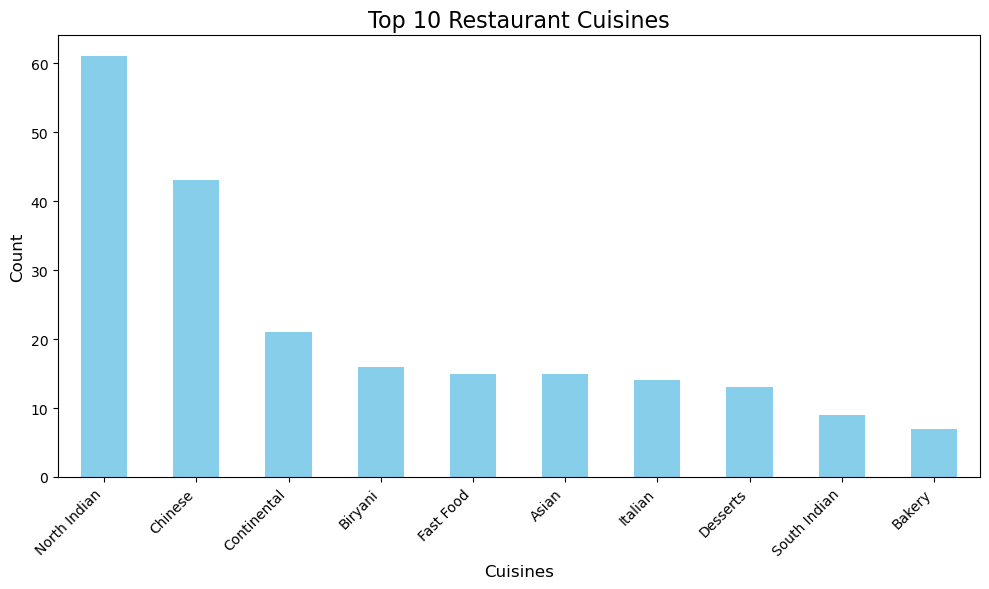

In [56]:
# Step 2: Count the occurrences of each unique category
collection_counts = cuisines_exploded.value_counts()

# Step 3: Plot the top categories (you can adjust the number of top categories to show)
top_categories = collection_counts.head(10)  # Showing the top 10 categories

# Plot the bar chart
plt.figure(figsize=(10,6))
top_categories.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Top 10 Restaurant Cuisines', fontsize=16)
plt.xlabel('Cuisines', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

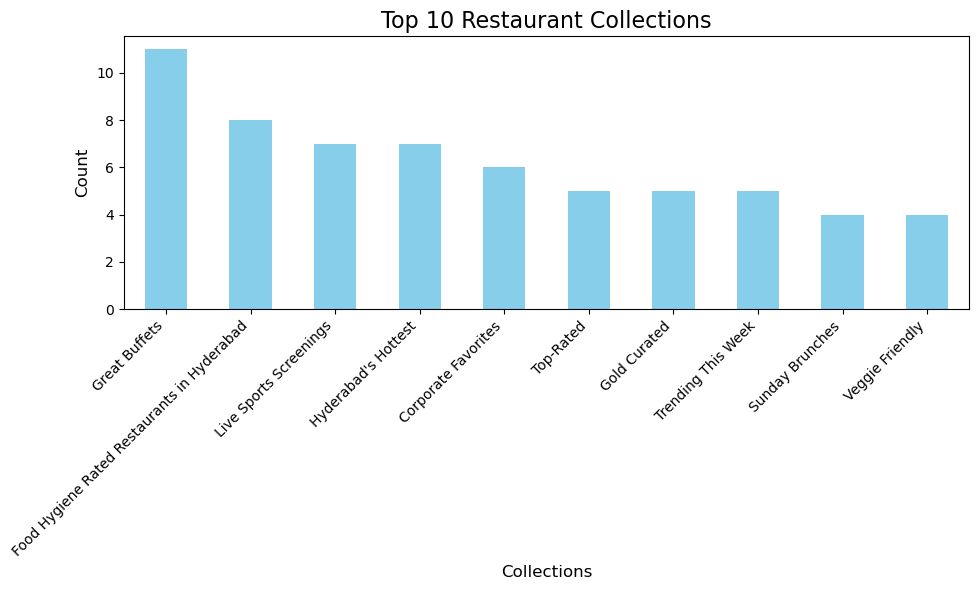

In [57]:
# Step 2: Count the occurrences of each unique category
collection_counts = collections_exploded.value_counts()

# Step 3: Plot the top categories (you can adjust the number of top categories to show)
top_categories = collection_counts.head(10)  # Showing the top 10 categories

# Plot the bar chart
plt.figure(figsize=(10,6))
top_categories.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Top 10 Restaurant Collections', fontsize=16)
plt.xlabel('Collections', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [58]:
print('How many times a reviewer posted')
reviews['Reviewer'].value_counts().sort_values(ascending=False)

How many times a reviewer posted


Parijat Ray              13
Ankita                   13
Kiran                    12
Vedant Killa             11
Jay Mehta                11
                         ..
Manish Singh              1
Kshitiz Goyal             1
Deepali K. Nagrani        1
Laxminarayana Amuraji     1
Bhargava Krishna          1
Name: Reviewer, Length: 7446, dtype: int64

In [59]:
print('How many reviews each restaurant has')
reviews['Restaurant'].value_counts().sort_values(ascending=True)

How many reviews each restaurant has


American Wild Wings                 77
Arena Eleven                        85
Behrouz Biryani                    100
Over The Moon Brew Company         100
The Fisherman's Wharf              100
                                  ... 
Zega - Sheraton Hyderabad Hotel    100
Triptify                           100
Royal Spicy Restaurant             100
Faasos                             100
Gal Punjab Di                      100
Name: Restaurant, Length: 100, dtype: int64

<Axes: >

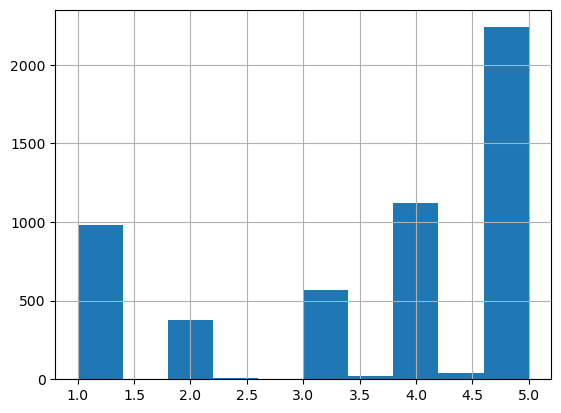

In [60]:
reviews[reviews['Post_Meal'] == 1]['Rating'].hist()

In [61]:
reviews.groupby('Restaurant').mean()

C:\Users\mnasc\AppData\Local\Temp\ipykernel_13520\1368241081.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reviews.groupby('Restaurant').mean()


,Rating,Pictures,N_reviews,Followers,Month,Year,Weekend,Post_Meal
Restaurant,,,,,,,,
10 Downing Street,3.80,1.05,39.90,261.414894,5.60,2018.67,0.40,0.44
13 Dhaba,3.48,0.41,17.70,114.280000,6.82,2018.39,0.49,0.60
"3B's - Buddies, Bar & Barbecue",4.76,0.13,3.70,17.278351,4.68,2019.00,0.31,0.81
AB's - Absolute Barbecues,4.88,0.24,2.71,10.600000,5.00,2019.00,0.47,0.85
Absolute Sizzlers,3.62,0.45,11.67,225.369863,3.62,2019.00,0.34,0.53
...,...,...,...,...,...,...,...,...
Urban Asia - Kitchen & Bar,3.65,1.78,39.34,209.021739,6.79,2018.44,0.28,0.55
Yum Yum Tree - The Arabian Food Court,3.56,1.29,19.84,131.845238,6.88,2018.30,0.40,0.45
Zega - Sheraton Hyderabad Hotel,4.45,0.83,27.38,351.841463,6.57,2018.22,0.23,0.45
